<a href="https://colab.research.google.com/github/ChanceDurr/DS-Unit-2-Applied-Modeling/blob/master/module4-model-interpretation/Chance_model_interpretation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import packages and csv's

In [0]:
import pandas as pd
from glob import glob
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split
!pip install category_encoders eli5 pdpbox shap
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBRegressor
import eli5
from eli5.sklearn import PermutationImportance

In [0]:
!wget https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/caterpillar/caterpillar-tube-pricing.zip

--2019-07-25 21:51:11--  https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/caterpillar/caterpillar-tube-pricing.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 823789 (804K) [application/zip]
Saving to: ‘caterpillar-tube-pricing.zip.1’

caterpillar-tube-pr 100%[===================>] 804.48K  --.-KB/s    in 0.06s   

2019-07-25 21:51:11 (12.3 MB/s) - ‘caterpillar-tube-pricing.zip.1’ saved [823789/823789]



In [0]:
!unzip caterpillar-tube-pricing.zip

Archive:  caterpillar-tube-pricing.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: sample_submission.csv   
  inflating: data.zip                


In [0]:
!unzip data.zip

Archive:  data.zip
replace competition_data/bill_of_materials.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: competition_data/bill_of_materials.csv  
  inflating: competition_data/comp_adaptor.csv  
  inflating: competition_data/comp_boss.csv  
  inflating: competition_data/comp_elbow.csv  
  inflating: competition_data/comp_float.csv  
  inflating: competition_data/comp_hfl.csv  
  inflating: competition_data/comp_nut.csv  
  inflating: competition_data/comp_other.csv  
  inflating: competition_data/comp_sleeve.csv  
  inflating: competition_data/comp_straight.csv  
  inflating: competition_data/comp_tee.csv  
  inflating: competition_data/comp_threaded.csv  
  inflating: competition_data/components.csv  
  inflating: competition_data/specs.csv  
  inflating: competition_data/test_set.csv  
  inflating: competition_data/train_set.csv  
  inflating: competition_data/tube.csv  
  inflating: competition_data/tube_end_form.csv  
  inflating: competition_data/type_component.csv 

In [0]:
def rmsle(y_true, y_pred):
  return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [0]:
for path in glob('competition_data/*.csv'):
    df = pd.read_csv(path)
    print(path, df.shape)

competition_data/comp_other.csv (1001, 3)
competition_data/comp_adaptor.csv (25, 20)
competition_data/components.csv (2048, 3)
competition_data/type_end_form.csv (8, 2)
competition_data/tube.csv (21198, 16)
competition_data/comp_elbow.csv (178, 16)
competition_data/type_connection.csv (14, 2)
competition_data/train_set.csv (30213, 8)
competition_data/comp_tee.csv (4, 14)
competition_data/comp_straight.csv (361, 12)
competition_data/comp_float.csv (16, 7)
competition_data/comp_boss.csv (147, 15)
competition_data/comp_hfl.csv (6, 9)
competition_data/comp_nut.csv (65, 11)
competition_data/tube_end_form.csv (27, 2)
competition_data/comp_sleeve.csv (50, 10)
competition_data/test_set.csv (30235, 8)
competition_data/bill_of_materials.csv (21198, 17)
competition_data/comp_threaded.csv (194, 32)
competition_data/specs.csv (21198, 11)
competition_data/type_component.csv (29, 2)


In [0]:
train_set = pd.read_csv('competition_data/train_set.csv')
test = pd.read_csv('competition_data/test_set.csv')

#Train / Val Split

In [0]:
train_set['quote_date'] = pd.to_datetime(train_set['quote_date'], infer_datetime_format=True)

In [0]:
assemblies = train_set['tube_assembly_id'].unique()
train_tube_assemblies, val_tube_assemblies = train_test_split(
    assemblies, random_state=47)
print(train_tube_assemblies.shape)
print(val_tube_assemblies.shape)

(6641,)
(2214,)


In [0]:
train = train_set[train_set['tube_assembly_id'].isin(train_tube_assemblies)]
val = train_set[train_set['tube_assembly_id'].isin(val_tube_assemblies)]

#Validation RMSLE, Mean Baseline

In [0]:
target = 'cost'
y_true = val[target]
y_pred = np.full_like(y_true, fill_value=train[target].mean())
rmsle(y_pred, y_true)

0.950350338860588

# Random Forest Regressor

In [0]:
from sklearn.ensemble import RandomForestRegressor

features = ['quantity']
target = 'cost'

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

model = RandomForestRegressor(n_estimators=100, random_state=47)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

rmsle(y_pred, y_val)

0.687755369078692

In [0]:
model = RandomForestRegressor(n_estimators=100, random_state=47)
model.fit(X_train, np.log1p(y_train))
y_pred = model.predict(X_val)

rmsle(np.expm1(y_pred), y_val)

0.6208119734988891

# XGB

In [0]:
tube = pd.read_csv('competition_data/tube.csv')

In [0]:
# Merge tube df on assembly id
train = pd.merge(train, tube, how='inner', on='tube_assembly_id')
val = pd.merge(val, tube, how='inner', on='tube_assembly_id')
test = pd.merge(test, tube, how='inner', on='tube_assembly_id')

In [0]:
train.head()

,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity,cost,material_id,diameter,wall,length,num_bends,bend_radius,end_a_1x,end_a_2x,end_x_1x,end_x_2x,end_a,end_x,num_boss,num_bracket,other
0,TA-00004,S-0066,2013-07-07,0,0,Yes,1,21.972702,SP-0019,6.35,0.71,137.0,9,19.05,N,N,N,N,EF-008,EF-008,0,0,0
1,TA-00004,S-0066,2013-07-07,0,0,Yes,2,12.407983,SP-0019,6.35,0.71,137.0,9,19.05,N,N,N,N,EF-008,EF-008,0,0,0
2,TA-00004,S-0066,2013-07-07,0,0,Yes,5,6.668596,SP-0019,6.35,0.71,137.0,9,19.05,N,N,N,N,EF-008,EF-008,0,0,0
3,TA-00004,S-0066,2013-07-07,0,0,Yes,10,4.754539,SP-0019,6.35,0.71,137.0,9,19.05,N,N,N,N,EF-008,EF-008,0,0,0
4,TA-00004,S-0066,2013-07-07,0,0,Yes,25,3.608331,SP-0019,6.35,0.71,137.0,9,19.05,N,N,N,N,EF-008,EF-008,0,0,0


In [0]:
features = ['quantity', 'length', 'num_bends',
            'bend_radius', 'diameter', 'end_a',
            'end_x', 'material_id', 'wall']
target = 'cost'

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

In [0]:
model = XGBRegressor(n_estimators=100, random_state=47)
pipe = make_pipeline(OrdinalEncoder(), model)
pipe.fit(X_train, np.log1p(y_train))
y_pred = pipe.predict(X_val)

[21:59:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [0]:
rmsle(np.expm1(y_pred), y_val)

0.4802520611127336

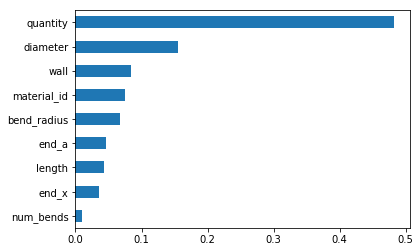

In [0]:
feature_importances = pd.Series(model.feature_importances_, features)
feature_importances.sort_values().plot.barh();

#Hyper Param/ CV

In [0]:
X_test = test

In [0]:
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline

features = ['quantity', 'length', 'num_bends',
            'bend_radius', 'diameter', 'end_a',
            'end_x', 'material_id', 'wall']
target = 'cost'

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
y_train_log = np.log1p(y_train)
X_test = test

groups = train['tube_assembly_id']

pipeline = make_pipeline(
    OrdinalEncoder(),
    XGBRegressor(random_state=47)
)

param_distributions = {
    'xgbregressor__n_estimators': [x for x in range(450, 500, 1)]
}

search = RandomizedSearchCV(
    pipeline,
    param_distributions = param_distributions,
    n_iter = 5,
    cv = 5,
    scoring = 'neg_mean_squared_error',
    verbose=10,
    return_train_score = True,
    n_jobs = -1
)


search.fit(X_train, y_train_log, groups=groups);

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   42.5s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  1.3min finished


[22:00:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [0]:
print(f'Best Hyperparameters: {search.best_params_}')
print(f'Cross_validation RMSLE: {np.sqrt(-search.best_score_)}')

Best Hyperparameters: {'xgbregressor__n_estimators': 459}
Cross_validation RMSLE: 0.49775265387276435


# Permutation


In [0]:
import eli5
from eli5.sklearn import PermutationImportance

In [0]:
permuter = PermutationImportance(model, scoring='neg_mean_squared_error', 
                                 cv='prefit', n_iter=2, random_state=42)
encoder = OrdinalEncoder()
X_val_encoded = encoder.fit_transform(X_val)
y_val_log = np.log1p(y_val)

permuter.fit(X_val_encoded, y_val_log)
feature_names = X_val_encoded.columns.tolist()
eli5.show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
0.4674 ± 0.0111,quantity
0.0934 ± 0.0039,diameter
0.0299 ± 0.0030,length
0.0225 ± 0.0026,end_a
0.0196 ± 0.0004,wall
0.0095 ± 0.0002,bend_radius
0.0008 ± 0.0013,end_x
-0.0004 ± 0.0000,num_bends
-0.0010 ± 0.0010,material_id


# PDP

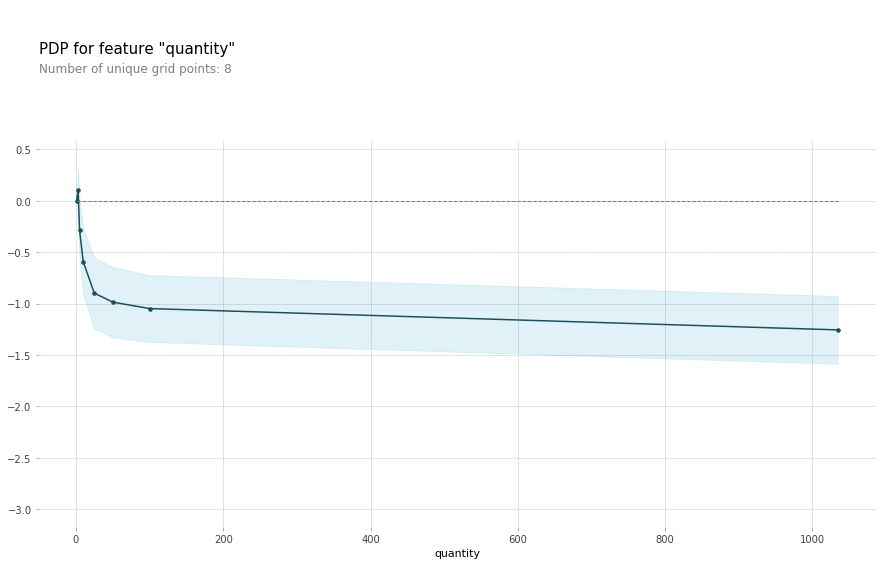

In [0]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'quantity'

isolated = pdp_isolate(
    model=model, 
    dataset=X_val_encoded, 
    model_features=X_val_encoded.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

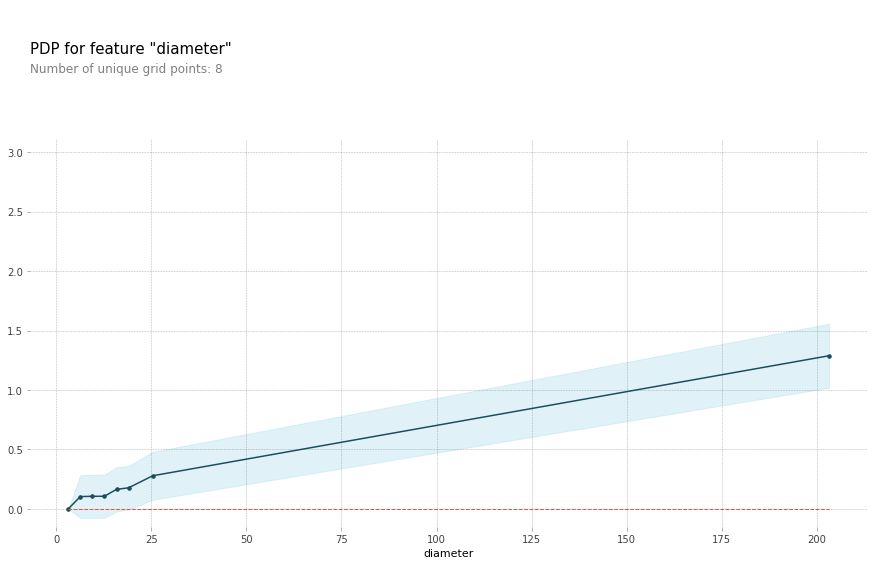

In [0]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'diameter'

isolated = pdp_isolate(
    model=model, 
    dataset=X_val_encoded, 
    model_features=X_val_encoded.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

#Test

In [0]:
y_pred = pipe.predict(test[features])

In [0]:
test.describe()

,id,annual_usage,min_order_quantity,quantity,diameter,wall,length,num_bends,bend_radius,num_boss,num_bracket,other
count,30235.000000,3.023500e+04,30235.000000,30235.000000,30235.000000,30235.000000,30235.000000,30235.000000,30235.000000,30235.000000,30235.000000,30235.000000
mean,15118.000000,2.521253e+02,2.297503,37.959782,17.335842,1.375376,99.902491,3.863238,44.621570,0.025765,0.004134,0.015876
std,8728.237031,2.021673e+04,21.083151,70.365779,18.392260,0.670536,62.808473,2.206852,244.583923,0.191343,0.075531,0.148684
min,1.000000,0.000000e+00,0.000000,1.000000,3.180000,0.710000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7559.500000,0.000000e+00,0.000000,2.000000,9.520000,0.890000,50.000000,2.000000,19.050000,0.000000,0.000000,0.000000
50%,15118.000000,0.000000e+00,0.000000,10.000000,12.700000,1.240000,89.000000,4.000000,31.750000,0.000000,0.000000,0.000000
75%,22676.500000,2.000000e+00,0.000000,40.000000,19.050000,1.650000,137.000000,5.000000,50.800000,0.000000,0.000000,0.000000
max,30235.000000,3.498645e+06,2500.000000,2500.000000,203.200000,7.900000,600.000000,17.000000,9999.000000,5.000000,4.000000,6.000000


In [0]:
sub = pd.DataFrame(data = {
    'id': test['id'],
    'cost': np.expm1(y_pred)
})
sub.to_csv('submission.csv', index=False)

In [0]:
sub.head()

,id,cost
0,1,14.958055
1,2,15.061894
2,3,9.914221
3,4,7.378201
4,5,5.514894


# Shapley

In [0]:
X_test = X_test[features]
X_test['predictions'] = y_pred
X_test.head(10)

,quantity,length,num_bends,bend_radius,diameter,end_a,end_x,material_id,wall,predictions
0,1,164.0,5,38.10,12.70,EF-003,EF-003,SP-0035,1.65,2.769964
1,2,164.0,5,38.10,12.70,EF-003,EF-003,SP-0035,1.65,2.776450
2,5,164.0,5,38.10,12.70,EF-003,EF-003,SP-0035,1.65,2.390067
3,10,164.0,5,38.10,12.70,EF-003,EF-003,SP-0035,1.65,2.125633
4,25,164.0,5,38.10,12.70,EF-003,EF-003,SP-0035,1.65,1.874091
5,50,164.0,5,38.10,12.70,EF-003,EF-003,SP-0035,1.65,1.838151
6,100,164.0,5,38.10,12.70,EF-003,EF-003,SP-0035,1.65,1.807665
7,250,164.0,5,38.10,12.70,EF-003,EF-003,SP-0035,1.65,1.805023
8,1,127.0,7,19.05,6.35,EF-008,EF-008,SP-0019,0.71,3.002550
9,2,127.0,7,19.05,6.35,EF-008,EF-008,SP-0019,0.71,2.702234


In [0]:
processor = make_pipeline(OrdinalEncoder())
X_train_processed = processor.fit_transform(X_train)
model = XGBRegressor(n_estimators=459, random_state=47)
model.fit(X_train_processed, y_train_log)

[22:18:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=459,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=47,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [0]:
data_for_prediction = X_test[X_test.index == 30212]

In [0]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(data_for_prediction_processed)
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction_processed)